In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision as tv
from torch.utils import data
from tqdm import tqdm
import time
import os
import numpy as np


from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg16

import copy
from collections import namedtuple

In [4]:
torch.cuda.empty_cache()

In [89]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
device

device(type='cuda')

In [5]:
!nvidia-smi

Mon Jul  3 16:03:15 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 532.03                 Driver Version: 532.03       CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                      TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3060       WDDM | 00000000:06:00.0  On |                  N/A |
|  0%   38C    P8               16W / 170W|   2384MiB / 12288MiB |      1%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [109]:
image_size = 256 
batch_size = 8 
data_root = 'root/'
use_gpu = True
style_path = 'com.jpg
lr = 1e-3 
plot_every = 100 
epoches = 2 # Учебные раунды
content_weight = 1e5 # content_loss weight
style_weight = 1e10 # style_loss weight
model_path = None # Предварительно обученный путь модели
save_path = ''
content_path = 'example.jpg' # Картинки, требующие передачи стиля
result_path = 'output.jpg' # Путь для сохранения результата после миграции стиля
mean = [0.485,0.456,0.406] # Средний
std = [0.229,0.224,0.225] # Дисперсия
IMAGENET_MEAN = [0.485,0.456,0.406] # Жадный
IMAGENET_STD = [0.229,0.224,0.225] # Дисперсия

In [77]:
class Vgg16(nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        features = list(vgg16(pretrained=True).features[:23])
        self.features = nn.ModuleList(features).eval()

    def forward(self, x):
        results = []
        
        for ii,model in enumerate(self.features):
            x = model(x)
            
            if ii in {3, 8, 15, 22}:
                results.append(x)

        vgg_outputs = namedtuple("VggOutputs",['relu1_2','relu2_2','relu3_3','relu4_3'])
        
        return vgg_outputs(*results)

In [78]:
class TransformerNet(nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()

        self.initial_layers = nn.Sequential(
            ConvLayer(3, 32, kernel_size=9, stride=1),
            nn.InstanceNorm2d(32, affine=True),
            nn.ReLU(True),
            ConvLayer(32, 64, kernel_size=3, stride=2),
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(True),
            ConvLayer(64, 128, kernel_size=3, stride=2),
            nn.InstanceNorm2d(128, affine=True),
            nn.ReLU(True))

        self.res_layers = nn.Sequential(
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128))

        self.upsample_layers = nn.Sequential(
            UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2),
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(True),
            UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2),
            nn.InstanceNorm2d(32, affine=True),
            nn.ReLU(True),
            ConvLayer(32, 3, kernel_size=9, stride=1))

    def forward(self, x):
        out = self.initial_layers(x)
        out = self.res_layers(out)
        out = self.upsample_layers(out)
        
        return out

    
class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()

        reflection_padding = int(np.floor(kernel_size / 2)) 
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding) 
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):  
        out = self.reflection_pad(x) 
        out = self.conv2d(out)
        
        return out
    
    
class UpsampleConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()

        self.upsample = upsample 
        reflection_padding = int(np.floor(kernel_size / 2))
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        if self.upsample: 
            x = F.interpolate(x, scale_factor=self.upsample)
            
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        
        return out

    
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1) 
        self.in1 = nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = nn.InstanceNorm2d(channels, affine=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.in1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.in2(out)
        out = out + identity 
        
        return out

In [79]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a, b, c * d) 
    features_t = features.transpose(1,2)

    return features.bmm(features_t) / (b * c * d)


def get_style_data(path):
    style_transform = tv.transforms.Compose([
        tv.transforms.ToTensor(),
        tv.transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ])

    style_image = tv.datasets.folder.default_loader(path)
    style_tensor = style_transform(style_image)
    
    return style_tensor.unsqueeze(0)


def normalize_batch(batch):
    mean = batch.data.new(IMAGENET_MEAN).view(1, -1, 1, 1)
    std = batch.data.new(IMAGENET_STD).view(1, -1, 1, 1)
    mean = (mean.expand_as(batch.data))
    std = (std.expand_as(batch.data)) 
    
    return (batch / 255.0 - mean) / std

In [99]:
def train(**kwargs):
    transforms = tv.transforms.Compose([
        tv.transforms.Resize(image_size),
        tv.transforms.CenterCrop(image_size),
        tv.transforms.ToTensor(),
        tv.transforms.Lambda(lambda x:x*255)
    ])
    dataset = tv.datasets.ImageFolder(data_root, transforms)
    dataloader = data.DataLoader(dataset, batch_size, drop_last=True)
    print("Dataset:",len(dataset),"Dataloader:",len(dataloader)) 
    
    transformer = TransformerNet().cuda()
    if model_path:
        print("Конверсионная модель успешно участвовала в загрузке!")
        transformer.load_state_dict(torch.load(model_path, map_location=lambda _s,_:_s))

    vgg = Vgg16().cuda().eval() 
    for param in vgg.parameters():
        param.requires_grad = False 

    optimizer = optim.Adam(transformer.parameters(), lr)

    style = get_style_data(style_path)
    style = style.cuda()
    
    with torch.no_grad():
        features_style = vgg(style) 
        gram_style = [gram_matrix(y) for y in features_style]
    
    now = time.time()
    for epoch in range(epoches):
        c_loss = 0
        s_loss = 0
        
        for ii, x in enumerate(tqdm(dataloader)):
            x, _ = x 
            optimizer.zero_grad() 
            x = x.cuda()
            y = transformer(x) 
            y = normalize_batch(y)
            x = normalize_batch(x)
            features_y = vgg(y)
            features_x = vgg(x)

            content_loss = content_weight * F.mse_loss(features_y.relu3_3, features_x.relu3_3)

            style_loss = 0
            for ft_y,gm_s in zip(features_y, gram_style):
                gram_y = gram_matrix(ft_y)
                style_loss += F.mse_loss(gram_y, gm_s.expand_as(gram_y))
                
            style_loss *= style_weight

            total_loss = content_loss + style_loss
            total_loss.backward()
            optimizer.step()

            c_loss = content_loss.item()
            s_loss = style_loss.item()
            
            if ii % plot_every == 0:
                tv.utils.save_image((y.data.cpu()[0]*0.225 + 0.45).clamp(min=0, max=1),'%s_output_%s.png' % (epoch,ii), normalize=True, range=(-1, 1))
            
            if ii % 1000 == 0:
                print("Epoch:{},C_Loss:{:.6f},S_Loss:{:.6f},Time:{:.4f}s".format(epoch,c_loss/8000,s_loss/8000,time.time()-now))
                
        torch.save(transformer.state_dict(),'%s_style.pth' % epoch)


def stylize(**kwargs):
    with torch.no_grad():

        content_image = tv.datasets.folder.default_loader(content_path)
        content_transform = tv.transforms.Compose([
            tv.transforms.ToTensor(),
            tv.transforms.Lambda(lambda x: x.mul(255))
        ])
        content_image = content_transform(content_image)
        content_image = content_image.unsqueeze(0).cuda().detach()

        style_model = TransformerNet().eval()
        style_model.load_state_dict(torch.load(model_path, map_location=lambda _s,_:_s))
        style_model = style_model.cuda()

        output = style_model(content_image)
        output_data = output.cpu().data[0]
        tv.utils.save_image(((output_data/255)).clamp(min=0,max=1), result_path)

In [110]:
train()

Dataset: 82783 Dataloader: 10347


  0%|                                                                              | 1/10347 [00:00<1:11:06,  2.42it/s]

Epoch:0,C_Loss:186.918688,S_Loss:1994.821375,Time:0.4134s


 10%|███████▍                                                                     | 1001/10347 [05:28<51:41,  3.01it/s]

Epoch:0,C_Loss:158.032641,S_Loss:83.917984,Time:328.3887s


 19%|██████████████▉                                                              | 2001/10347 [10:51<46:46,  2.97it/s]

Epoch:0,C_Loss:135.928078,S_Loss:69.580727,Time:651.6566s


 29%|██████████████████████▎                                                      | 3001/10347 [16:23<41:51,  2.92it/s]

Epoch:0,C_Loss:140.867953,S_Loss:64.201289,Time:983.0599s


 39%|█████████████████████████████▊                                               | 4001/10347 [21:54<35:56,  2.94it/s]

Epoch:0,C_Loss:131.419844,S_Loss:63.447887,Time:1314.9270s


 48%|█████████████████████████████████████▏                                       | 5001/10347 [27:28<29:27,  3.02it/s]

Epoch:0,C_Loss:106.007625,S_Loss:57.987492,Time:1648.0659s


 58%|████████████████████████████████████████████▋                                | 6001/10347 [32:57<23:59,  3.02it/s]

Epoch:0,C_Loss:109.712195,S_Loss:56.399137,Time:1977.7863s


 68%|████████████████████████████████████████████████████                         | 7001/10347 [38:27<18:45,  2.97it/s]

Epoch:0,C_Loss:112.303844,S_Loss:56.086734,Time:2307.8887s


 77%|███████████████████████████████████████████████████████████▌                 | 8001/10347 [44:19<14:49,  2.64it/s]

Epoch:0,C_Loss:107.470344,S_Loss:58.125598,Time:2659.5253s


 87%|██████████████████████████████████████████████████████████████████▉          | 9001/10347 [50:26<08:24,  2.67it/s]

Epoch:0,C_Loss:119.298836,S_Loss:49.166602,Time:3026.7818s


 97%|█████████████████████████████████████████████████████████████████████████▍  | 10001/10347 [56:33<02:11,  2.63it/s]

Epoch:0,C_Loss:104.182812,S_Loss:51.326223,Time:3393.2221s


  0%|                                                                              | 1/10347 [00:00<1:09:38,  2.48it/s]

Epoch:1,C_Loss:116.646055,S_Loss:60.915027,Time:3521.5277s


 10%|███████▍                                                                     | 1001/10347 [06:05<57:11,  2.72it/s]

Epoch:1,C_Loss:102.412758,S_Loss:62.407793,Time:3886.8164s


 19%|██████████████▉                                                              | 2001/10347 [12:14<51:47,  2.69it/s]

Epoch:1,C_Loss:103.999531,S_Loss:57.619094,Time:4255.3542s


 29%|██████████████████████▎                                                      | 3001/10347 [18:21<44:31,  2.75it/s]

Epoch:1,C_Loss:115.196773,S_Loss:58.906090,Time:4622.5769s


 39%|█████████████████████████████▊                                               | 4001/10347 [24:29<39:38,  2.67it/s]

Epoch:1,C_Loss:114.034797,S_Loss:57.978887,Time:4990.5583s


 48%|█████████████████████████████████████▏                                       | 5001/10347 [30:36<32:57,  2.70it/s]

Epoch:1,C_Loss:93.903563,S_Loss:54.516902,Time:5357.3201s


 58%|████████████████████████████████████████████▋                                | 6001/10347 [36:43<26:49,  2.70it/s]

Epoch:1,C_Loss:99.461664,S_Loss:53.191133,Time:5724.6123s


 68%|████████████████████████████████████████████████████                         | 7001/10347 [42:49<20:41,  2.69it/s]

Epoch:1,C_Loss:103.264664,S_Loss:53.526809,Time:6090.5098s


 77%|███████████████████████████████████████████████████████████▌                 | 8001/10347 [48:39<12:56,  3.02it/s]

Epoch:1,C_Loss:98.626047,S_Loss:56.345949,Time:6440.1694s


 87%|██████████████████████████████████████████████████████████████████▉          | 9001/10347 [54:09<07:24,  3.03it/s]

Epoch:1,C_Loss:109.511086,S_Loss:49.634316,Time:6770.5372s


 97%|█████████████████████████████████████████████████████████████████████████▍  | 10001/10347 [59:40<01:56,  2.98it/s]

Epoch:1,C_Loss:96.203203,S_Loss:50.176305,Time:7101.3132s


100%|██████████████████████████████████████████████████████████████████████████| 10347/10347 [1:01:33<00:00,  2.80it/s]


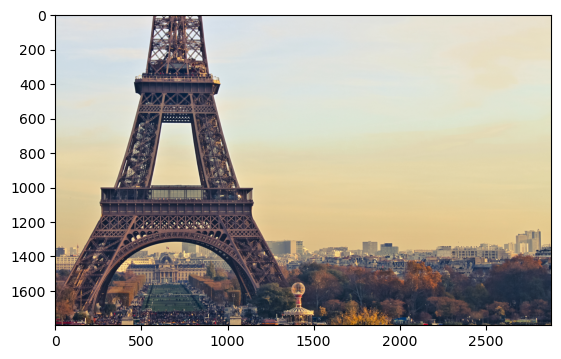

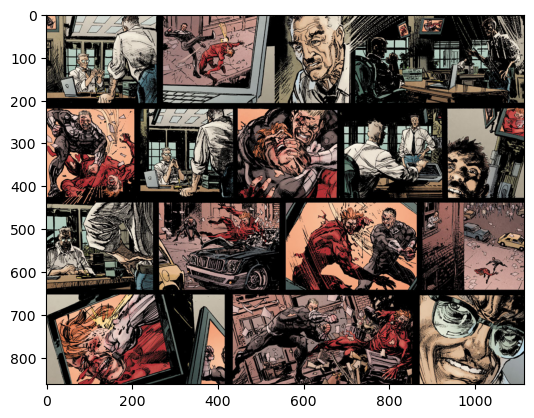

In [14]:
plt.figure()
plt.imshow(np.asarray(Image.open('example.jpeg')))

plt.figure()
plt.imshow(np.asarray(Image.open('com.jpg')))

In [121]:
model_path='0_style.pth'
content_path='1.jpg'
stylize()

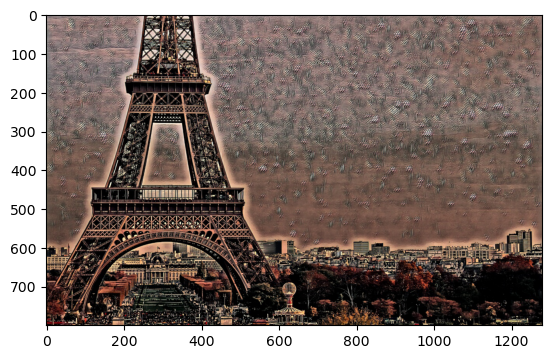

In [15]:
img = np.asarray(Image.open('output.jpg'))
plt.imshow(img)